In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm
import os
from rasta import rastaplp
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
sr = 16000

In [2]:
dropout = 0.3
half = False

## EDA

Unnamed: 0                                                69361
anchor_speaker                                      Dick_Schaap
anchor_file         trainfiles/start_segments/b960610aseg22.npy
positive_file         trainfiles/end_segments/b960604aseg41.npy
negative_speaker                                Kimberly_Dosier
negative_file         trainfiles/end_segments/eh971016seg87.npy
Name: 69361, dtype: object
0.22504444365279486


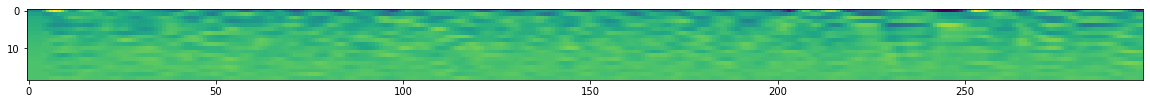

In [3]:
triplets = pd.read_csv('trainfiles/triplets.csv')
#triplets = triplets[triplets['anchor_speaker'] == 'i960711p_anchor2']
idx = np.random.randint(0, len(triplets))
triplet = triplets.iloc[idx]
anchor_segment = np.fromfile(triplet['anchor_file'], dtype = np.int16)/(2**15)
positive_segment = np.fromfile(triplet['positive_file'], dtype = np.int16)/(2**15)
negative_segment = np.fromfile(triplet['negative_file'], dtype = np.int16)/(2**15)
print(triplet)
print(anchor_segment.std())

S_dB = rastaplp(np.concatenate((anchor_segment, positive_segment, negative_segment)), modelorder = 18) # 32 ms window, 10 ms hop
plt.figure(figsize = (20, 30))
plt.imshow(S_dB)
ipd.Audio(np.concatenate((anchor_segment, positive_segment, negative_segment)), rate = sr)

(19, 298)
different


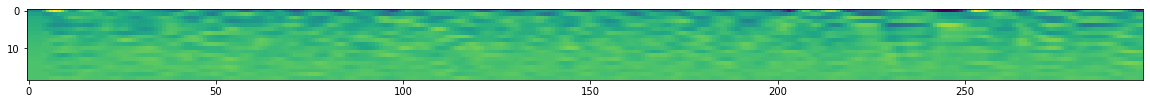

In [4]:
pairs = pd.read_csv('trainfiles/pairs.csv')
idx = np.random.randint(0, len(pairs))
pair = pairs.iloc[idx]
first_segment = np.fromfile(pair['first_file'], dtype = np.int16)/(2**15)
second_segment = np.fromfile(pair['second_file'], dtype = np.int16)/(2**15)
S_dB = rastaplp(np.concatenate((anchor_segment, positive_segment, negative_segment)), modelorder = 18) # 32 ms window, 10 ms hop
print(S_dB.shape)
plt.figure(figsize = (20, 30))
plt.imshow(S_dB)
if pair['label']:
    print('different')
else:
    print('same')
ipd.Audio(np.concatenate((first_segment, second_segment)), rate = sr)


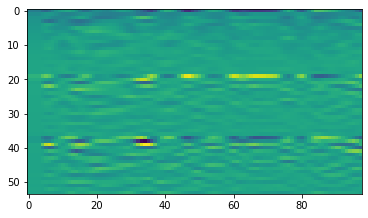

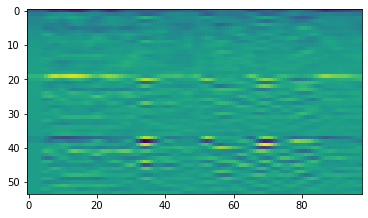

In [28]:
class TripletsDataSet(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.triplets = pd.read_csv('trainfiles/triplets.csv')
    def __len__(self):
        return len(self.triplets)
    def get_plp(self, filename):
        plp_path = 'plp/'+filename
        if os.path.exists(plp_path):
            return np.load(plp_path)
        else:
            seg = np.fromfile(filename, dtype = np.int16)/(2**15)
            S_dB = self.make_spectrogram(seg)
            np.save(plp_path, S_dB)
            return S_dB
    def __getitem__(self, idx):
        triplet = self.triplets.iloc[idx]
        anchor_segment = self.get_plp(triplet['anchor_file'])
        positive_segment = self.get_plp(triplet['positive_file'])
        negative_segment = self.get_plp(triplet['negative_file'])
        return anchor_segment, positive_segment, negative_segment
    def make_spectrogram(self, segment):
        S_dB = rastaplp(segment, modelorder = 18) # 32 ms window, 10 ms hop
        S_dB_d1 = np.diff(S_dB, n = 1, axis = 0)
        S_dB_d2 = np.diff(S_dB, n = 2, axis = 0)
        return np.concatenate((S_dB, S_dB_d1, S_dB_d2), axis = 0).T # add channel dimension
trainset = TripletsDataSet()
class PairsDataSet(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.pairs = pd.read_csv('trainfiles/pairs.csv')
    def __len__(self):
        return len(self.pairs)
    def get_plp(self, filename):
        plp_path = 'plp/'+filename
        if os.path.exists(plp_path):
            return np.load(plp_path)
        else:
            seg = np.fromfile(filename, dtype = np.int16)/(2**15)
            S_dB = self.make_spectrogram(seg)
            np.save(plp_path, S_dB)
            return S_dB
    def __getitem__(self, idx):
        pair = self.pairs.iloc[idx]
        seg1 = self.get_plp(pair['first_file'])
        seg2 = self.get_plp(pair['second_file'])
        label = pair['label']
        return (seg1, seg2), label
    def make_spectrogram(self, segment):
        S_dB = rastaplp(segment, modelorder = 18) # 32 ms window, 10 ms hop
        S_dB_d1 = np.diff(S_dB, n = 1, axis = 0)
        S_dB_d2 = np.diff(S_dB, n = 2, axis = 0)
        return np.concatenate((S_dB, S_dB_d1, S_dB_d2), axis = 0).T # add channel dimension
trainset_cls = PairsDataSet()
idx = np.random.randint(len(trainset_cls))
plt.imshow(trainset_cls[idx][0][np.random.randint(2)].T)

class TestSet(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.pairs = pd.read_csv('testfiles/pairs.csv')
    def __len__(self):
        return len(self.pairs)
    def get_plp(self, filename):
        plp_path = 'plp/'+filename
        if os.path.exists(plp_path):
            return np.load(plp_path)
        else:
            seg = np.fromfile(filename, dtype = np.int16)/(2**15)
            S_dB = self.make_spectrogram(seg)
            np.save(plp_path, S_dB)
            return S_dB
    def __getitem__(self, idx):
        pair = self.pairs.iloc[idx]
        seg1 = self.get_plp(pair['first_file'])
        seg2 = self.get_plp(pair['second_file'])
        label = pair['label']
        return (seg1, seg2), label
    def make_spectrogram(self, segment):
        S_dB = rastaplp(segment, modelorder = 18) # 32 ms window, 10 ms hop
        S_dB_d1 = np.diff(S_dB, n = 1, axis = 0)
        S_dB_d2 = np.diff(S_dB, n = 2, axis = 0)
        return np.concatenate((S_dB, S_dB_d1, S_dB_d2), axis = 0).T # add channel dimension
testset = TestSet()
idx = np.random.randint(len(testset))
plt.figure()
plt.imshow(testset[idx][0][np.random.randint(2)].T)

## Causal version, slow, maybe try torch jit

In [6]:
class Spectral_Attention(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Spectral_Attention, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = nn.LSTM(input_size, hidden_size, num_layers, batch_first = False)
        self.attention = nn.Linear(hidden_size*num_layers, input_size) # can replace this with better attention mechanism
    def zero_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda(),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda())
    def forward(self, X, prev_state = None, mask = None): # X: (sequence length, batch, hidden size)
        batch_size = X.shape[1]
        if prev_state == None: # if we don't initialize hidden state
            prev_state = self.zero_state(batch_size)
        if mask == None:
            mask = torch.ones(batch_size, self.input_size).cuda()
        outputs = []
        for t, x in enumerate(X):
            x = x*mask
            x = x[None, ...] # 1, batch, hidden_size
            output, (state_h, state_c) = self.cell(x, prev_state)
            prev_state = (state_h, state_c)
            state_h = state_h.view(batch_size, -1)
            mask = self.attention(state_h)
            outputs.append(output)
        outputs = torch.cat(outputs, dim = 0)
        return outputs

## Noncausal version with Residual Attention

In [7]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels//4, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels//4, output_channels//4, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels//4, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

class AttentionModule_stage1(nn.Module):
    # input size is 56*56
    def __init__(self, in_channels, out_channels, size1=(200, 128), size2=(100, 64), size3=(50, 32)):
        super(AttentionModule_stage1, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax2_blocks = ResidualBlock(in_channels, out_channels)

        self.skip2_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax3_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)

        self.softmax4_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)

        self.softmax5_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax6_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        #batch_size, nheads, length, n_mels = x.shape
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x) # 100x64
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1) # 50x32
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2) # 25x16
        out_softmax3 = self.softmax3_blocks(out_mpool3) 
        #
        out_interp3 = self.interpolation3(out_softmax3) + out_softmax2
        # print(out_skip2_connection.data)
        # print(out_interp3.data)
        out = out_interp3 + out_skip2_connection
        out_softmax4 = self.softmax4_blocks(out)
        out_interp2 = self.interpolation2(out_softmax4) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp1 = self.interpolation1(out_softmax5) + out_trunk
        out_softmax6 = self.softmax6_blocks(out_interp1)
        out = (1 + out_softmax6) * out_trunk
        out_last = self.last_blocks(out)
        return out_last

num_heads = 4
siamese = nn.Sequential(nn.LSTM(54, 32, 3, batch_first = True, bidirectional = True, dropout = dropout), # batch_size * 200 * n_hidden
                    Lambda(lambda x: x[0].mean(dim = 1)), # batch * n_hidden
                    nn.Dropout(dropout),
                    nn.Linear(64, 32),
                    nn.Tanh(),
                    nn.Dropout(dropout),
                    nn.Linear(32, 32),
                    nn.Tanh(), # batch * n_embedding
                    Lambda(lambda x: torch.nn.functional.normalize(x, 2, 1)) # L2 normalize across n_hidden
                    ).cuda()
# tune hidden layers smaller if overfit
optimizer = torch.optim.Adam(siamese.parameters(), 0.001)

if os.path.exists('models/baseline-siamese.pth'):
    print('load model')
    checkpoint = torch.load('models/baseline-siamese.pth')
    siamese.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']

if half:
    siamese.half()  # convert to half precision
    for layer in siamese.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.float()
            
siamese.train()

load model


Sequential(
  (0): LSTM(54, 32, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (1): Lambda()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): Tanh()
  (8): Lambda()
)

## Things to try: Maybe add a multi-headed timewise attention to LSTM output? See if it focuses on attack of sounds? Actually, I can pretrain using tanh+averaging, then during classification, apply tanh+concat+MHA

## Pre-train embedding

In [29]:
class TripletLoss(nn.Module):
    def __init__(self, margin = 0.3):
        super(TripletLoss, self).__init__()
        self.margin = margin
    def forward(self, anchor, positive, negative, size_average=True):
        # anchor - positive shape is batch_size * n_embedding
        distance_positive = (anchor - positive).pow(2).sum(1).pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1).pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, pin_memory = True, num_workers = 8)
criterion = TripletLoss()

lasttime = time.time()
for epoch in range(6):
    running_loss = 0.0
    for batch_idx, (X_anchor, X_pos, X_neg) in enumerate(trainloader):
        optimizer.zero_grad()
        if half:
            X_anchor, X_pos, X_neg = X_anchor.half(), X_pos.half(), X_neg.half()
        else:
            X_anchor, X_pos, X_neg = X_anchor.float(), X_pos.float(), X_neg.float()
        X_anchor, X_pos, X_neg = X_anchor.cuda(), X_pos.cuda(), X_neg.cuda()
        out_anchor, out_pos, out_neg = siamese(X_anchor), siamese(X_pos), siamese(X_neg)
        loss = criterion(out_anchor, out_pos, out_neg)
        loss.backward()
        optimizer.step()



        running_loss += loss.item()
        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 200))
            running_loss = 0.0
            torch.save({
            'model_state_dict': siamese.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'models/baseline-siamese.pth')
        #measure time
        #print('batch time: ', str(time.time()-lasttime)[:4])
        lasttime = time.time()

[1,   200] loss: 0.034
[1,   400] loss: 0.035
[1,   600] loss: 0.035
[1,   800] loss: 0.035
[1,  1000] loss: 0.037
[1,  1200] loss: 0.036
[1,  1400] loss: 0.038
[1,  1600] loss: 0.036
[1,  1800] loss: 0.035
[1,  2000] loss: 0.036
[1,  2200] loss: 0.036
[1,  2400] loss: 0.036
[1,  2600] loss: 0.036
[1,  2800] loss: 0.038
[1,  3000] loss: 0.035
[1,  3200] loss: 0.034
[1,  3400] loss: 0.038
[1,  3600] loss: 0.037
[1,  3800] loss: 0.037
[1,  4000] loss: 0.037
[1,  4200] loss: 0.036
[1,  4400] loss: 0.037
[1,  4600] loss: 0.038
[1,  4800] loss: 0.036
[1,  5000] loss: 0.037
[1,  5200] loss: 0.036
[1,  5400] loss: 0.035
[1,  5600] loss: 0.036
[1,  5800] loss: 0.037
[1,  6000] loss: 0.036
[1,  6200] loss: 0.036
[1,  6400] loss: 0.035
[1,  6600] loss: 0.033
[1,  6800] loss: 0.037
[2,   200] loss: 0.035
[2,   400] loss: 0.036
[2,   600] loss: 0.033
[2,   800] loss: 0.036
[2,  1000] loss: 0.033
[2,  1200] loss: 0.035
[2,  1400] loss: 0.038
[2,  1600] loss: 0.035
[2,  1800] loss: 0.035
[2,  2000] 

KeyboardInterrupt: 

## Train Classifier ##
# Add Dropout

In [8]:
class Classifier(nn.Module):
    def __init__(self, siamese):
        super().__init__()
        self.siamese = siamese
        self.fc1 = nn.Sequential(nn.Dropout(0.3), nn.Linear(64, 64), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Dropout(0.3), nn.Linear(64, 64), nn.ReLU())
        self.out = nn.Sequential(nn.Dropout(0.3), nn.Linear(64, 1)) # sigmoid is in loss
    def forward(self, x1, x2):
        embedding_1 = self.siamese(x1) # batch_size * n_embedding
        embedding_2 = self.siamese(x2) # batch_size * n_embedding
        x = torch.cat([embedding_1, embedding_2], dim = 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x).view(x1.shape[0])

cls = Classifier(siamese).cuda()
optimizer = torch.optim.Adam(cls.parameters(), 0.001)

if os.path.exists('models/baseline-cls.pth'):
    print('load model')
    checkpoint = torch.load('models/baseline-cls.pth')
    cls.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']

if half:
    cls.half()  # convert to half precision
    for layer in cls.modules():
        if isinstance(layer, nn.BatchNorm2d):
            cls.float()
cls.train()



load model


Classifier(
  (siamese): Sequential(
    (0): LSTM(54, 32, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
    (1): Lambda()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Lambda()
  )
  (fc1): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
  )
  (out): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
trainloader_cls = torch.utils.data.DataLoader(trainset_cls, batch_size=32, shuffle=True, pin_memory = True, num_workers = 8)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, pin_memory = True, num_workers = 8)
criterion = nn.BCEWithLogitsLoss()
lasttime = time.time()

for epoch in range(30):
    running_loss = 0.0
    running_accuracy = 0.0
    enum = iter(testloader)
    for batch_idx, ((X_1, X_2), label) in enumerate(trainloader_cls):
        optimizer.zero_grad()
        if half:
            X_1, X_2 = X_1.half(), X_2.half()
        else:
            X_1, X_2 = X_1.float(), X_2.float()
        X_1, X_2, label = X_1.cuda(), X_2.cuda(), label.cuda()
        out = cls(X_1, X_2)
        label = label.float()
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += sum((out.data.cpu().numpy()>0) == label.data.cpu().numpy())/32
        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f' % 
                  (epoch + 1, batch_idx + 1, running_loss / 200, running_accuracy / 200))
            running_loss = 0.0
            running_accuracy = 0.0
            torch.save({
            'model_state_dict': cls.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'models/baseline-cls.pth')
            
            
            (X_1, X_2), label = next(enum)
            if half:
                X_1, X_2 = X_1.half(), X_2.half()
            else:
                X_1, X_2 = X_1.float(), X_2.float()
            X_1, X_2, label = X_1.cuda(), X_2.cuda(), label.cuda()
            cls.eval()
            out = cls(X_1, X_2)
            label = label.float()
            print('test accuracy: ', sum((out.data.cpu().numpy()>0) == label.data.cpu().numpy())/64)
            print()
            if sum((out.data.cpu().numpy()>0) == label.data.cpu().numpy())/64 > 0.85:
                torch.save({
                'model_state_dict': cls.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, 'models/best-baseline-cls.pth')
            cls.train()
            
            
        #measure time
        #print('batch time: ', str(time.time()-lasttime)[:4])
        lasttime = time.time()


[1,   200] loss: 0.304 accuracy: 0.878
test accuracy:  0.734375

[1,   400] loss: 0.329 accuracy: 0.869
test accuracy:  0.640625

[1,   600] loss: 0.314 accuracy: 0.871
test accuracy:  0.734375

[1,   800] loss: 0.323 accuracy: 0.872
test accuracy:  0.75

[1,  1000] loss: 0.321 accuracy: 0.869
test accuracy:  0.703125

[1,  1200] loss: 0.321 accuracy: 0.872
test accuracy:  0.71875

[1,  1400] loss: 0.324 accuracy: 0.869
test accuracy:  0.6875

[1,  1600] loss: 0.321 accuracy: 0.873
test accuracy:  0.578125

[1,  1800] loss: 0.317 accuracy: 0.868
test accuracy:  0.734375

[1,  2000] loss: 0.312 accuracy: 0.872
test accuracy:  0.703125

[1,  2200] loss: 0.322 accuracy: 0.866
test accuracy:  0.578125

[1,  2400] loss: 0.311 accuracy: 0.879
test accuracy:  0.8125

[1,  2600] loss: 0.317 accuracy: 0.875
test accuracy:  0.703125

[1,  2800] loss: 0.317 accuracy: 0.873
test accuracy:  0.671875

[1,  3000] loss: 0.315 accuracy: 0.874
test accuracy:  0.71875

[1,  3200] loss: 0.317 accuracy: 0.